In [27]:
import pandas as pd
import numpy as np
import datetime
import time
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score
from sklearn.cluster import KMeans

from scipy.optimize import minimize, LinearConstraint #for optimization

## Helper functions


In [165]:
def calc_return(total_pymnt, term, funded_amnt, recoveries, realized_loan_term_mths, r=0.01):
    effective_monthly_installments = (total_pymnt - recoveries)/realized_loan_term_mths
    
    #get total cash flow at loan termination as the geometric sum of effective monthly installments
    #yielding a constant rate of return rr.
    #This is from assumption #1
    rr =r/12 #expecting r to be the annual yield
    total_cash_flow = effective_monthly_installments * ((1 - (1 + rr)**realized_loan_term_mths)) / (1 - (1 + rr))
    
    #add back recoveries to the get the lump sum at loan termination.
    total_cash_flow+= recoveries 

    #assumption #2. invest at rr till original term of loan.
    total_cash_flow = total_cash_flow * ((1 + rr)**(max(0,term - realized_loan_term_mths)))
    
    #calculate total return R and annualize
    R = (total_cash_flow - funded_amnt) / funded_amnt
    return ((1+R)**(12/term) - 1)



def fit_return_models(X_train, Y_train, X_test, Y_test, model_name ="Ridge",
                      cv_parameters = {},
                      random_state = 1980):
    '''
    fits 2 return models using the sklearn model object implied by model name. One model for loans that defaulted and another for 
    loans that didn't default.
    code borrowed mostly from the danguetta.com paper/notebook.
    '''
    
    np.random.seed(random_state)
    
    #choose model based on user selection
    if model_name == "Lasso":
        model = linear_model.Lasso(normalize=True)
    elif model_name == "Ridge":
        model = linear_model.Ridge(normalize=True)
    elif model_name == "RandomF":
        model = RandomForestRegressor()

    
 
    #split data into defaulted series and non-defaulted series

    Y_train_bad = Y_train.loc[(Y_train._good == 0),['id', 'annualized_returns'] ]
    X_train_bad = X_train[X_train.id.isin(Y_train_bad.id)]
    Y_test_bad  = Y_test.loc[(Y_test._good == 0),['id', 'annualized_returns'] ]
    X_test_bad  = X_test[X_test.id.isin(Y_test_bad.id)]
    
    Y_train_good = Y_train.loc[(Y_train._good == 1),['id', 'annualized_returns'] ]
    X_train_good = X_train[X_train.id.isin(Y_train_good.id)]  
    Y_test_good  = Y_test.loc[(Y_test._good == 1),['id', 'annualized_returns'] ]
    X_test_good  = X_test[X_test.id.isin(Y_test_good.id)]

    
    ##remove ids for now to be added back afterwards
    train_bad_loan_ids = X_train_bad.pop('id')
    test_bad_loan_ids = pd.DataFrame(X_test_bad.pop('id'), columns=['id'])


    train_good_loan_ids = X_train_good.pop('id')
    test_good_loan_ids = pd.DataFrame(X_test_good.pop('id'), columns=['id'])
    

    
    ##drop ids from Y datasets
    Y_train_good.drop('id', axis =1, inplace=True)
    Y_train_bad.drop('id', axis=1, inplace=True)
    
    Y_test_good.drop('id', axis =1, inplace=True)
    Y_test_bad.drop('id', axis =1, inplace=True)
    

    
    ##run model
    cv_model_bad = GridSearchCV(model, cv_parameters, scoring='r2', n_jobs=-1)
    cv_model_good = GridSearchCV(model, cv_parameters, scoring='r2', n_jobs=-1)

    #time and fit the models
    start_time = time.time()
    print("fitting model for defaulted loans")
    if model_name in ['RandomF']:
        cv_model_bad.fit(X_train_bad, Y_train_bad.values.ravel())
    else:
        cv_model_bad.fit(X_train_bad, Y_train_bad)
        
    print("fitting model for non-defaulted loans")
    if model_name in ['RandomF']:
        cv_model_good.fit(X_train_good, Y_train_good.values.ravel())
    else:
        cv_model_good.fit(X_train_good, Y_train_good)
        
    end_time = time.time()

    #pick best model from the fit for each regressor
    best_model_bad = cv_model_bad.best_estimator_
    best_model_good = cv_model_good.best_estimator_
            
    #tidy outputs    
    print("=========================")
    print("  Model: " + model_name )
    print("=========================")

    print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
    print("Optimal parameters:")
    print("model_default:",cv_model_bad.best_params_, "model_non-default",cv_model_good.best_params_)

    ##predicted returns - need to join back to get loan ids
    predicted_non_default_return = pd.DataFrame(best_model_good.predict(X_test_good), columns =['ret'])
    predicted_default_return     = pd.DataFrame(best_model_bad.predict(X_test_bad), columns =['ret'])
    
    
    ## add ids back
    predicted_non_default_return = list(zip(test_good_loan_ids.id, predicted_non_default_return.ret))
    
    predicted_default_return = list(zip(test_bad_loan_ids.id, predicted_default_return.ret))
    
    print("")
    print("Testing r2 scores:")
    # Here we use different testing set to report the performance
    test_scores = {'model_default':r2_score(Y_test_bad,best_model_bad.predict(X_test_bad)),
                      'model_non_default':r2_score(Y_test_good,best_model_good.predict(X_test_good))}
 
    print("model_default:", test_scores['model_default'])
    print("model_non_default:", test_scores['model_non_default'])

    return { 'model_default':best_model_bad, 'model_non_default':best_model_good, 'predicted_non_default_return':predicted_non_default_return,
              'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

    
    
##create risk scores

def var_95(ret):
    return np.percentile(ret,  5)

def var_99(ret):
    return np.percentile(ret, 1)

def ES_95(ret):
    threshold = var_95(ret)
    return np.mean(ret[ret < threshold])

def ES_99(ret):
    threshold = var_99(ret)
    return np.mean(ret[ret < threshold])


##calculate expected returns
def calc_expected_ret(good, p, pred_ret_good, pred_ret_bad):
    if good:
        return (p * pred_ret_good) + ((1-p) * pred_ret_bad)
    else:
        return (p * pred_ret_bad)  + ((1-p) * pred_ret_good)
    

##optimization routines
def neg_risk_penalized_ret(notionals, pred_ret, risk, lambda_c):
    risk_adj_ret = pred_ret - (lambda_c * np.abs(risk))
    neg_ret = -1 * sum([x[0]*x[1] for x in zip(notionals, risk_adj_ret)])
    #print("Iterating:", neg_ret)
    return neg_ret



def portfolio_optimize(pred_ret,  funded_amts, budget = 1e6, lambda_c = 0.01, risk_measure = 1, risk_std=[], risk_ES=[]):
    '''
    risk can be either standard deviations or Expected Shortfall. Expected Shortfall is reported as negative
    so take the abs of the quantities there.
    risk_measure={0:standard deviation, 1:Expected shortfall}
    '''    
    if risk_measure:
        risk = risk_ES
    else:
        risk = risk_std
    
    assert(len(pred_ret) == len(risk) == len(funded_amts))

    init_notionals = [budget/len(pred_ret)] * len(pred_ret) #initialize variables
    arguments = (pred_ret, risk, lambda_c) #arguments into the objective function other than the variables
    
    linear_constraint = LinearConstraint(np.ones(len(init_notionals)), lb=0, ub=budget)  #total investment<=budget
    
    var_bounds = [(0, funded_amts[i]) for i in range(len(funded_amts))]
    
    opt_portfolio = minimize(neg_risk_penalized_ret, init_notionals,
                             args=arguments,
                             constraints=linear_constraint,
                             bounds=var_bounds,
                             method='SLSQP',
                             options={'ftol': 1e-5, 'disp': True, 'maxiter': 2000 }
                            )
    return opt_portfolio

###end of optimization routines

##portfolio returns routines
def calc_realized_returns(optimal_portf):
    '''
    join with the returns dataframe to get the realized returns for each selected loan
    
    '''
    optimal_portf = pd.merge(optimal_portf, ret_df[['id','annualized_returns']], how='left', on='id')
    optimal_portf.annualized_returns.fillna(0, inplace=True)
    assert(len(optimal_portf.optimal_notionals) ==  len(optimal_portf.annualized_returns))
    num = np.sum([x[0]*x[1] for x in zip(optimal_portf.optimal_notionals, optimal_portf.annualized_returns)])
    den = np.sum(optimal_portf.optimal_notionals)
    return(num/den)


##portfolio returns routines
def get_optimized_portfolios(id_values, ret, funded_amnt, risk_aversion, risk_measure, risk):
    start_time = time.time()
    if risk_measure:
        opt_expected_ret_ES = portfolio_optimize(ret,
                                          funded_amnt, lambda_c = risk_aversion, \
                                          risk_measure = risk_measure, risk_ES=risk
                                         )
    else:
        opt_expected_ret_ES = portfolio_optimize(ret,
                                          funded_amnt, lambda_c = risk_aversion, \
                                          risk_measure = risk_measure, risk_std=risk
                                         )
    end_time = time.time()
    print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
    print("Risk aversion parameter:", risk_aversion)
    
    opt_df = pd.DataFrame({'id':id_values, 'funded_amnt': funded_amnt, \
                  'optimal_notionals':opt_expected_ret_ES.x})
    opt_df.optimal_notionals = opt_df.optimal_notionals.apply(lambda val: round(val))
    return opt_df


##get std dev and ES_95 per subgroup
def calc_risk_measures(X_train_, Y_train_):
    tmp = pd.merge(X_train_[['id', 'grade', 'sub_grade', 'term']], Y_train_, how='inner', on='id')
    return(pd.DataFrame(tmp.groupby(['sub_grade'])['annualized_returns'].agg(['count', 'median' , 'mean', 'min','max', 'std', var_95, var_99, ES_95, ES_99])).reset_index())



### get predicted returns and return them in a df
def get_2_scenario_pred_returns(ridge_res, rf_res,X_test_,useRidge=1):
    #make predictions on the test sample using both models
    if useRidge:
        pred_ret_if_non_defaulting = ridge_res['model_non_default'].predict(X_test_.drop('id', axis=1))[:,0]
        pred_ret_if_defaulting = ridge_res['model_default'].predict(X_test_.drop('id', axis=1))[:,0]
    else:
        pred_ret_if_non_defaulting = rf_res['model_non_default'].predict(X_test_.drop('id', axis=1))
        pred_ret_if_defaulting = rf_res['model_default'].predict(X_test_.drop('id', axis=1))

    ##combine the predicted returns into a single dataframe to join with predicted default probs
    pred_returns_good =pd.DataFrame({'id': X_test_.id, 'pred_ret_good': pred_ret_if_non_defaulting })
    pred_returns_bad =pd.DataFrame({'id': X_test_.id.values, 'pred_ret_bad': pred_ret_if_defaulting})

    return(pd.merge(pred_returns_good, pred_returns_bad, how='inner', on='id'))



def encode_grades_term(def_predictions):
    ##convert grade, sub_grade and term to numbers - from Dmitri's notebook
    sub_grades = sorted(def_predictions.sub_grade.unique())
    sub_grades_dict = {x:sub_grades.index(x)+1 for x in sub_grades}  # map 'A1' to 1 rather than 0

    ordinal_dict = {
        'grade':   {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7},
        'sub_grade': sub_grades_dict,
        'term': {' 36 months':0, ' 60 months':1}
    }

    for f in ['grade', 'sub_grade','term']:
        def_predictions[f].replace(ordinal_dict[f], inplace=True)
    
    return def_predictions


##calc expected returns from the 2 scenario model return outputs
def calc_expected_ret(good, p, pred_ret_good, pred_ret_bad):
    if good:
        return (p * pred_ret_good) + ((1-p) * pred_ret_bad)
    else:
        return (p * pred_ret_bad)  + ((1-p) * pred_ret_good)
    

##as the function name suggests :)
def assign_risk_measures_by_subgrade(risk_summary_df,predictions_df):
    sub_grades = risk_summary_df.sub_grade.unique()
    for sg in sub_grades:
        std_dev = float(risk_summary_df[risk_summary_df.sub_grade == sg]['std'].values)
        ES_95 = float(risk_summary_df[risk_summary_df.sub_grade == sg]['ES_95'].values)

        predictions_df.loc[(predictions_df.sub_grade == sg) ,'risk_std_dev'] = std_dev
        predictions_df.loc[(predictions_df.sub_grade == sg),'risk_ES_95'] = ES_95
    return predictions_df

## End Helper functions


In [3]:
#read in Dmitri's files
X_full = pd.read_csv("data/seq/X_full_1592769980.csv")
Y_full = pd.read_csv("data/seq/Y_full_1592769980.csv")
Y_proba = pd.read_csv("data/seq/Y_predictions_1592769980.csv")


In [4]:
dtypes_map={
'id':'uint32',
'application_type':'uint8',
'grade':'uint8',
'sub_grade':'uint8',
'term':'uint8',
'initial_list_status':'uint8',
'emp_length':'uint8',
'verification_status':'uint8',
'_has_desc':'uint8',
'purpose_credit_card':'uint8',
'purpose_debt_consolidation':'uint8',
'purpose_educational':'uint8',
'purpose_home_improvement':'uint8',
'purpose_house':'uint8',
'purpose_major_purchase':'uint8',
'purpose_medical':'uint8',
'purpose_moving':'uint8',
'purpose_other':'uint8',
'purpose_renewable_energy':'uint8',
'purpose_small_business':'uint8',
'purpose_vacation':'uint8',
'purpose_wedding':'uint8',
'home_ownership_OTHER':'uint8',
'home_ownership_OWN':'uint8',
'home_ownership_RENT':'uint8'
}

In [5]:
#change dtypes for numericals to reduce storage and increase computational efficiency
X_full = X_full.astype(dtype=dtypes_map)
Y_proba = Y_proba.astype({'id': 'uint32'})

In [8]:
print(X_full.shape)
print(Y_full.shape)
print(Y_proba.shape)

(1345100, 37)
(1345100, 2)
(1339819, 3)


In [14]:
#get the full dataset as well as some attributes not available at investment time is needed later for return calcs
LC_df = pd.read_csv("data/accepted_2007_to_2018Q4.csv")

/Users/rknatuahene/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
# Remove subtotal rows - from Simon
def find_weird(x):
    try:
        _ = int(x)
        return(True)
    except:
        return(False)
    
LC_df = LC_df[LC_df['id'].apply(find_weird)]
LC_df = LC_df.astype({'id': 'uint32'}) #make id dtype compatible with X_full df

In [17]:
LC_df = LC_df[LC_df.id.isin(X_full.id)]

In [20]:
print(LC_df.shape)
print(X_full.shape)

(1345100, 151)
(1345100, 37)


In [22]:
ret_df = LC_df[["id", "issue_d","last_pymnt_d", "total_pymnt", "term", "funded_amnt", "recoveries","grade","sub_grade","loan_status"]].copy()

In [23]:
ret_df.dropna(subset=["id", "issue_d","last_pymnt_d", "total_pymnt", "term", "funded_amnt"], inplace=True)

In [24]:
#convert term field to integer months
ret_df['term'] = ret_df['term'].apply(lambda t: np.int8(t.split()[0]))
ret_df.term.value_counts()

#convert issue_d and last_pymnt_d into datetime
ret_df['issue_d'] = ret_df['issue_d'].apply(lambda dt: datetime.datetime.strptime( dt, "%b-%Y").date())
ret_df['last_pymnt_d'] = ret_df['last_pymnt_d'].apply(lambda dt: datetime.datetime.strptime( dt, "%b-%Y").date())

In [25]:
#calculate the realized term of the loan in months. 
ret_df['realized_loan_term_mths'] = round((ret_df['last_pymnt_d'] - ret_df['issue_d'])/np.timedelta64(1, 'M'))

In [26]:
#remove rows where realized_loan_term_mths <= 0
ret_df = ret_df[ret_df.realized_loan_term_mths > 0]

In [29]:
##calc realized returns
rr = 0.01
ret_df["annualized_returns"] = ret_df.apply(lambda row: calc_return(row[3], row[4], row[5], row[6], row[10], rr), axis =1)

In [34]:
#merge returns data
X_full = pd.merge(X_full, ret_df[['id', 'issue_d']], how="left", on ='id')
Y_full = pd.merge(Y_full, ret_df[['id','annualized_returns', 'issue_d']], how="left", on ='id')

In [36]:
#remove NAs
X_full.dropna(inplace=True)
Y_full.dropna(inplace=True)

### Prepare cuts


#### Cut1. training:issue_d<2014, test:2014


In [59]:
X_pre2014 = X_full.loc[(pd.DatetimeIndex(X_full['issue_d']).year < 2014)].copy()
Y_pre2014 = Y_full[Y_full.id.isin(X_pre2014.id)].copy()
X_test_2014 = X_full.loc[(pd.DatetimeIndex(X_full['issue_d']).year == 2014)].copy()
Y_test_2014 = Y_full[Y_full.id.isin(X_test_2014.id)].copy()

In [60]:
assert(Y_pre2014.shape[0] == X_pre2014.shape[0])
assert(X_test_2014.shape[0] == Y_test_2014.shape[0])

In [70]:
print(X_pre2014.shape)
print(X_test_2014.shape)

(227475, 38)
(222928, 38)


#### Cut2. training:issue_d<2015, test:2015


In [66]:
X_pre2015 = X_full.loc[(pd.DatetimeIndex(X_full['issue_d']).year < 2015)].copy()
Y_pre2015 = Y_full[Y_full.id.isin(X_pre2015.id)].copy()
X_test_2015 = X_full.loc[(pd.DatetimeIndex(X_full['issue_d']).year == 2015)].copy()
Y_test_2015 = Y_full[Y_full.id.isin(X_test_2015.id)].copy()

In [67]:
assert(Y_pre2015.shape[0] == X_pre2015.shape[0])
assert(X_test_2015.shape[0] == Y_test_2015.shape[0])

In [71]:
print(X_pre2015.shape)
print(X_test_2015.shape)

(450403, 38)
(374158, 38)


#### Cut3. training:issue_d<2016, test:2016


In [68]:
X_pre2016 = X_full.loc[(pd.DatetimeIndex(X_full['issue_d']).year < 2016)].copy()
Y_pre2016 = Y_full[Y_full.id.isin(X_pre2016.id)].copy()
X_test_2016 = X_full.loc[(pd.DatetimeIndex(X_full['issue_d']).year == 2016)].copy()
Y_test_2016 = Y_full[Y_full.id.isin(X_test_2016.id)].copy()

In [69]:
assert(Y_pre2016.shape[0] == X_pre2016.shape[0])
assert(X_test_2016.shape[0] == Y_test_2016.shape[0])

In [72]:
print(X_pre2016.shape)
print(X_test_2016.shape)

(824561, 38)
(290033, 38)


In [73]:
##drop issue date from the data sets
X_pre2014.drop('issue_d', axis=1, inplace=True) 
Y_pre2014.drop('issue_d', axis=1, inplace=True) 
X_test_2014.drop('issue_d', axis=1, inplace=True)  
Y_test_2014.drop('issue_d', axis=1, inplace=True)  

X_pre2015.drop('issue_d', axis=1, inplace=True)  
Y_pre2015.drop('issue_d', axis=1, inplace=True) 
X_test_2015.drop('issue_d', axis=1, inplace=True)  
Y_test_2015.drop('issue_d', axis=1, inplace=True)  

X_pre2016.drop('issue_d', axis=1, inplace=True)  
Y_pre2016.drop('issue_d', axis=1, inplace=True)   
X_test_2016.drop('issue_d', axis=1, inplace=True)  
Y_test_2016.drop('issue_d', axis=1, inplace=True)  

## Test regression models


### Ridge

In [91]:
cv_parameters = {'alpha': np.logspace(-12, 1, num = 20), 'max_iter' : [2000]}


In [92]:
reg_ridge_pre2014 = fit_return_models(X_pre2014, Y_pre2014, X_test_2014, Y_test_2014, model_name ="Ridge",
               cv_parameters = cv_parameters)

fitting model for defaulted loans
fitting model for non-defaulted loans
  Model: Ridge
Fit time: 12.45 seconds
Optimal parameters:
model_default: {'alpha': 1e-12, 'max_iter': 2000} model_non-default {'alpha': 0.018329807108324374, 'max_iter': 2000}

Testing r2 scores:
model_default: 0.034536543736483405
model_non_default: 0.35329566767254283


In [93]:
reg_ridge_pre2015 = fit_return_models(X_pre2015, Y_pre2015, X_test_2015, Y_test_2015, model_name ="Ridge",
               cv_parameters = cv_parameters)

fitting model for defaulted loans
fitting model for non-defaulted loans
  Model: Ridge
Fit time: 18.08 seconds
Optimal parameters:
model_default: {'alpha': 1e-12, 'max_iter': 2000} model_non-default {'alpha': 0.003792690190732254, 'max_iter': 2000}

Testing r2 scores:
model_default: -0.008906256923303602
model_non_default: 0.3661953015068562


In [94]:
reg_ridge_pre2016 = fit_return_models(X_pre2016, Y_pre2016, X_test_2016, Y_test_2016, model_name ="Ridge",
               cv_parameters = cv_parameters)

fitting model for defaulted loans
fitting model for non-defaulted loans
  Model: Ridge
Fit time: 40.15 seconds
Optimal parameters:
model_default: {'alpha': 0.003792690190732254, 'max_iter': 2000} model_non-default {'alpha': 0.0007847599703514623, 'max_iter': 2000}

Testing r2 scores:
model_default: -0.10840302503738086
model_non_default: 0.12358347854181406


### Random Forest

In [101]:
cv_parameters = {'min_samples_leaf':[100],
                 'n_estimators': [50] }

In [102]:
reg_rf_pre2014 = fit_return_models(X_pre2014, Y_pre2014, X_test_2014, Y_test_2014, model_name ="RandomF",
               cv_parameters = cv_parameters)

fitting model for defaulted loans
fitting model for non-defaulted loans
  Model: RandomF
Fit time: 179.55 seconds
Optimal parameters:
model_default: {'min_samples_leaf': 100, 'n_estimators': 50} model_non-default {'min_samples_leaf': 100, 'n_estimators': 50}

Testing r2 scores:
model_default: 0.04215233785671735
model_non_default: 0.36645073090604685


In [103]:
reg_rf_pre2015 = fit_return_models(X_pre2015, Y_pre2015, X_test_2015, Y_test_2015, model_name ="RandomF",
               cv_parameters = cv_parameters)

fitting model for defaulted loans
fitting model for non-defaulted loans
  Model: RandomF
Fit time: 417.92 seconds
Optimal parameters:
model_default: {'min_samples_leaf': 100, 'n_estimators': 50} model_non-default {'min_samples_leaf': 100, 'n_estimators': 50}

Testing r2 scores:
model_default: -0.0048677483222498985
model_non_default: 0.3899436465945678


In [104]:
reg_rf_pre2016 = fit_return_models(X_pre2016, Y_pre2016, X_test_2016, Y_test_2016, model_name ="RandomF",
               cv_parameters = cv_parameters)

fitting model for defaulted loans
fitting model for non-defaulted loans
  Model: RandomF
Fit time: 867.03 seconds
Optimal parameters:
model_default: {'min_samples_leaf': 100, 'n_estimators': 50} model_non-default {'min_samples_leaf': 100, 'n_estimators': 50}

Testing r2 scores:
model_default: -0.07457798174124397
model_non_default: 0.18325850482959505


In [150]:
#### create risk data.
risk_summary_sub_grades_all_pre2014 = calc_risk_measures(X_pre2014, Y_pre2014)
risk_summary_sub_grades_all_pre2015 = calc_risk_measures(X_pre2015, Y_pre2015)
risk_summary_sub_grades_all_pre2016 = calc_risk_measures(X_pre2016, Y_pre2016)


In [178]:
#make this a function
useRidge = 0;
if useRidge:
    regressor_used = "Ridge"
else:
    regressor_used = "RF"

combined_pred_returns_2014 = get_2_scenario_pred_returns(reg_ridge_pre2014, reg_rf_pre2014, X_test_2014, useRidge)
combined_pred_returns_2015 = get_2_scenario_pred_returns(reg_ridge_pre2015, reg_rf_pre2015, X_test_2015, useRidge)
combined_pred_returns_2016 = get_2_scenario_pred_returns(reg_ridge_pre2016, reg_rf_pre2016, X_test_2016, useRidge)


In [116]:
print(combined_pred_returns_2014.shape)
print(combined_pred_returns_2015.shape)
print(combined_pred_returns_2016.shape)

(222928, 3)
(374158, 3)
(290033, 3)


In [134]:
###get Classifier probabilities for each test year
def_predictions_2014 = Y_proba[Y_proba.id.isin(X_test_2014.id)].copy()
def_predictions_2015 = Y_proba[Y_proba.id.isin(X_test_2015.id)].copy()
def_predictions_2016 = Y_proba[Y_proba.id.isin(X_test_2016.id)].copy()

In [135]:
print(def_predictions_2014.shape)
print(def_predictions_2015.shape)
print(def_predictions_2016.shape)

(222928, 3)
(374158, 3)
(290033, 3)


In [129]:
### add [grade, sub_grade, term] to def_predictions
#get subset from prediction df
LC_subset_df = LC_df[LC_df.id.isin(Y_proba.id)]


In [136]:
def_predictions_2014 = pd.merge(def_predictions_2014, LC_subset_df[['id','grade','sub_grade','term','loan_amnt','funded_amnt']], how ='left', on='id')
def_predictions_2015 = pd.merge(def_predictions_2015, LC_subset_df[['id','grade','sub_grade','term','loan_amnt','funded_amnt']], how ='left', on='id')
def_predictions_2016 = pd.merge(def_predictions_2016, LC_subset_df[['id','grade','sub_grade','term','loan_amnt','funded_amnt']], how ='left', on='id')

In [140]:
def_predictions_2014 = encode_grades_term(def_predictions_2014)
def_predictions_2015 = encode_grades_term(def_predictions_2015)
def_predictions_2016 = encode_grades_term(def_predictions_2016)

In [142]:
##add predicted expected returns to default probabilities df
def_predictions_2014 = pd.merge(def_predictions_2014, combined_pred_returns_2014, how="left", on='id')
def_predictions_2015 = pd.merge(def_predictions_2015, combined_pred_returns_2015, how="left", on='id')
def_predictions_2016 = pd.merge(def_predictions_2016, combined_pred_returns_2016, how="left", on='id')

In [151]:
#calc expected returns
def_predictions_2014['pred_expected_ret'] = def_predictions_2014.apply(lambda row: calc_expected_ret(row._good, \
                                                                        row.p, row.pred_ret_good, row.pred_ret_bad), axis=1)


def_predictions_2015['pred_expected_ret'] = def_predictions_2015.apply(lambda row: calc_expected_ret(row._good, \
                                                                        row.p, row.pred_ret_good, row.pred_ret_bad), axis=1)

#calc expected returns
def_predictions_2016['pred_expected_ret'] = def_predictions_2016.apply(lambda row: calc_expected_ret(row._good, \
                                                                        row.p, row.pred_ret_good, row.pred_ret_bad), axis=1)


Text(0.5, 0, 'Annualized returns')

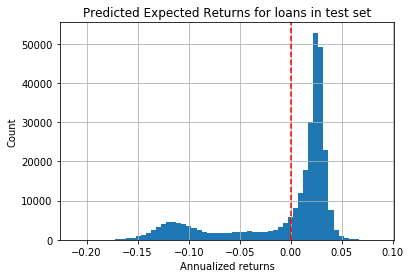

In [157]:
def_predictions_2016.hist('pred_expected_ret', bins=60)
pyplot.axvline(x=0, color='r', linestyle='--')
pyplot.title("Predicted Expected Returns for loans in test set")
pyplot.ylabel("Count")
pyplot.xlabel("Annualized returns")


In [166]:
##assign risk numbers to each loan in the test set
def_predictions_2014 = assign_risk_measures_by_subgrade(risk_summary_sub_grades_all_pre2014, def_predictions_2014)
def_predictions_2015 = assign_risk_measures_by_subgrade(risk_summary_sub_grades_all_pre2015, def_predictions_2015)
def_predictions_2016 = assign_risk_measures_by_subgrade(risk_summary_sub_grades_all_pre2016, def_predictions_2016)

In [168]:
def_predictions_2014.sample(10)

,id,_good,p,grade,sub_grade,term,loan_amnt,funded_amnt,pred_ret_good,pred_ret_bad,pred_expected_ret,risk_std_dev,risk_ES_95
170695,32029139,1,0.944839,2,7,0,20000.0,20000.0,0.047988,-0.138933,0.037677,0.075443,-0.258438
161116,6706517,1,0.953611,1,3,0,20000.0,20000.0,0.037000,-0.149016,0.028371,0.057599,-0.179887
38789,12408485,1,0.842910,4,16,0,5825.0,5825.0,0.077788,-0.167680,0.039227,0.112236,-0.348493
10896,10069844,1,0.803133,4,16,1,11325.0,11325.0,0.066140,-0.102281,0.032983,0.112236,-0.348493
154195,1599440,1,0.908792,2,7,0,33600.0,33600.0,0.046236,-0.176361,0.025933,0.075443,-0.258438
58108,13496978,1,0.945925,2,10,0,12000.0,12000.0,0.062872,-0.142770,0.051752,0.093420,-0.316136
166160,33180455,1,0.951546,1,1,0,15000.0,15000.0,0.033509,-0.161211,0.024074,0.043912,-0.101060
131841,24786420,1,0.915538,1,5,0,18000.0,18000.0,0.042799,-0.147794,0.026701,0.067285,-0.231327
171079,32129509,1,0.786103,3,12,0,6000.0,6000.0,0.067056,-0.166173,0.017169,0.095824,-0.312622
123865,22254888,1,0.926847,1,5,0,15000.0,15000.0,0.039876,-0.223430,0.020615,0.067285,-0.231327


## Test optimal portfolios


### seed with top n loans sorted by predicted expected returns
#### find optimal lambda

In [169]:
n = 100

In [173]:
top_by_expected_ret_2014 = (def_predictions_2014.loc[(def_predictions_2014.grade <= 5),['id','grade','pred_expected_ret','funded_amnt','risk_std_dev','risk_ES_95']].\
                        sort_values('pred_expected_ret', ascending=False)).iloc[:n,]
top_by_expected_ret_2015 = (def_predictions_2015.loc[(def_predictions_2015.grade <= 5),['id','grade','pred_expected_ret','funded_amnt','risk_std_dev','risk_ES_95']].\
                        sort_values('pred_expected_ret', ascending=False)).iloc[:n,]
top_by_expected_ret_2016 = (def_predictions_2016.loc[(def_predictions_2016.grade <= 5),['id','grade','pred_expected_ret','funded_amnt','risk_std_dev','risk_ES_95']].\
                        sort_values('pred_expected_ret', ascending=False)).iloc[:n,]

In [185]:
lambda_c =[0.1, 0.01, 0.005, 0.001, 0.0005]

In [186]:
#find the optimal risk_aversion parameter:
portf_ret_arr_2014 = [calc_realized_returns(get_optimized_portfolios(top_by_expected_ret_2014.id.values, 
                                                                top_by_expected_ret_2014.pred_expected_ret.values,
                                                                top_by_expected_ret_2014.funded_amnt.values,
                                                                risk_aversion_parameter, 1,
                                                                top_by_expected_ret_2014.risk_ES_95))\
 for risk_aversion_parameter in lambda_c]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -31079.068053510007
            Iterations: 135
            Function evaluations: 13770
            Gradient evaluations: 135
Fit time: 4.16 seconds
Risk aversion parameter: 0.1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -57853.60793852799
            Iterations: 120
            Function evaluations: 12240
            Gradient evaluations: 120
Fit time: 3.69 seconds
Risk aversion parameter: 0.01
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59341.08237853647
            Iterations: 123
            Function evaluations: 12546
            Gradient evaluations: 123
Fit time: 3.79 seconds
Risk aversion parameter: 0.005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -60531.06192906376
            Iterations: 122
            Function evaluations: 12444
            Gr

In [187]:
print("N=",n)
print("Regression algo:", regressor_used)
print("risk measure: ES")
print("Year: 2014")
pd.DataFrame({'lambda': lambda_c, 'max_returns':portf_ret_arr_2014}).sort_values('max_returns', ascending=False)

N= 100
Regression algo: RF
risk measure: ES
Year: 2014


,lambda,max_returns
0,0.1000,0.089359
1,0.0100,0.089359
2,0.0050,0.089359
3,0.0010,0.089359
4,0.0005,0.089359


In [188]:
#find the optimal risk_aversion parameter 2015:
portf_ret_arr_2015 = [calc_realized_returns(get_optimized_portfolios(top_by_expected_ret_2015.id.values, 
                                                                top_by_expected_ret_2015.pred_expected_ret.values,
                                                                top_by_expected_ret_2015.funded_amnt.values,
                                                                risk_aversion_parameter, 1,
                                                                top_by_expected_ret_2015.risk_ES_95))\
 for risk_aversion_parameter in lambda_c]

print("N=",n)
print("Regression algo:", regressor_used)
print("risk measure: ES")
print("Year: 2015")
pd.DataFrame({'lambda': lambda_c, 'max_returns':portf_ret_arr_2015}).sort_values('max_returns', ascending=False)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -24034.85767131417
            Iterations: 557
            Function evaluations: 56519
            Gradient evaluations: 554
Fit time: 16.5 seconds
Risk aversion parameter: 0.1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -53202.63092180664
            Iterations: 76
            Function evaluations: 7773
            Gradient evaluations: 76
Fit time: 2.35 seconds
Risk aversion parameter: 0.01
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -54904.224307346485
            Iterations: 117
            Function evaluations: 11945
            Gradient evaluations: 117
Fit time: 3.52 seconds
Risk aversion parameter: 0.005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -56405.24903013991
            Iterations: 306
            Function evaluations: 31019
            Gradi

,lambda,max_returns
4,0.0005,0.073652
2,0.0050,0.073302
1,0.0100,0.072728
3,0.0010,0.070845
0,0.1000,0.070220


In [189]:
#find the optimal risk_aversion parameter 2016:
portf_ret_arr_2016 = [calc_realized_returns(get_optimized_portfolios(top_by_expected_ret_2016.id.values, 
                                                                top_by_expected_ret_2016.pred_expected_ret.values,
                                                                top_by_expected_ret_2016.funded_amnt.values,
                                                                risk_aversion_parameter, 1,
                                                                top_by_expected_ret_2016.risk_ES_95))\
 for risk_aversion_parameter in lambda_c]

print("N=",n)
print("Regression algo:", regressor_used)
print("risk measure: ES")
print("Year: 2016")
pd.DataFrame({'lambda': lambda_c, 'max_returns':portf_ret_arr_2016}).sort_values('max_returns', ascending=False)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -36895.01632505506
            Iterations: 448
            Function evaluations: 45503
            Gradient evaluations: 446
Fit time: 14.53 seconds
Risk aversion parameter: 0.1
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -67587.07880928289
            Iterations: 805
            Function evaluations: 81722
            Gradient evaluations: 801
Fit time: 24.43 seconds
Risk aversion parameter: 0.01
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -68201.44821528891
            Iterations: 69
            Function evaluations: 7049
            Gradient evaluations: 69
Fit time: 2.14 seconds
Risk aversion parameter: 0.005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -69696.44282227308
            Iterations: 81
            Function evaluations: 8273
         

,lambda,max_returns
2,0.0050,0.071753
4,0.0005,0.071627
3,0.0010,0.071594
1,0.0100,0.071170
0,0.1000,0.070925


In [190]:
n= 100
risk_aversion =0.005 #optimal risk aversion parameter across the 3 years
print(regressor_used)

RF



#### 2014 cuts

In [193]:
# seed with top n loans sorted by predicted expected returns
top_selection_1 = (def_predictions_2014.loc[(def_predictions_2014.grade <= 5),['id','pred_expected_ret','funded_amnt','risk_std_dev','risk_ES_95']].\
                        sort_values('pred_expected_ret', ascending=False)).iloc[:n,]
top_selection_1.rename(columns={"pred_expected_ret": "pred_ret_good"},inplace=True)

# seed with top n loans sorted by predicted non_default returns
top_selection_2 = (def_predictions_2014.loc[(def_predictions_2014.grade <= 5),['id','pred_ret_good','funded_amnt','risk_std_dev','risk_ES_95']].\
                        sort_values('pred_ret_good', ascending=False)).iloc[:n,]

# seed with top n loans sorted by returns with highest probability of non-default
top_selection_3 = (def_predictions_2014.loc[(def_predictions_2014._good == 1) &(def_predictions_2014.grade <= 5),['id', '_good', 'p','pred_ret_good','funded_amnt','risk_std_dev','risk_ES_95']].\
                        sort_values('p', ascending=False)).iloc[:n,]

# seed with top n loans selected randomly
top_selection_4 = def_predictions_2014.loc[(def_predictions_2014.grade <= 5),['id', '_good','grade', 'p','pred_ret_good','funded_amnt','risk_std_dev','risk_ES_95']]
top_selection_4 = top_selection_4.iloc[(np.random.randint(0,top_selection_4.shape[0],n)),:]

top_selections = [top_selection_1, top_selection_2, top_selection_3, top_selection_4]

print("running optimizer through each filtered set of 100 loans")
opt_portf_arr_2014 = [get_optimized_portfolios(top_by_expected_ret.id.values, 
                                                                top_by_expected_ret.pred_ret_good.values,
                                                                top_by_expected_ret.funded_amnt.values,
                                                                risk_aversion, 1,
                                                                top_by_expected_ret.risk_ES_95) \
 for top_by_expected_ret in top_selections]

print("Now calculating realized returns of optimized portfolios")
simple_ret_arr_2014 = [calc_realized_returns(portf) for portf in opt_portf_arr_2014]

strategy =['Expected Returns,ES','R_non_default,any loan,ES',\
           'R_non_default,non-defaulting loans only,ES', \
           'Random,ES']
resultset_2014 = pd.DataFrame({'Filter': strategy, 'Realized_returns':simple_ret_arr_2014}).\
                sort_values('Realized_returns', ascending=False)

print("Risk aversion parameter:", risk_aversion, "\nRegressor:", regressor_used)
print("Year: 2014")
resultset_2014

running optimizer through each filtered set of 100 loans
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59341.08237853647
            Iterations: 123
            Function evaluations: 12546
            Gradient evaluations: 123
Fit time: 4.28 seconds
Risk aversion parameter: 0.005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -71168.92721278273
            Iterations: 49
            Function evaluations: 4998
            Gradient evaluations: 49
Fit time: 1.55 seconds
Risk aversion parameter: 0.005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -32903.4262819064
            Iterations: 50
            Function evaluations: 5111
            Gradient evaluations: 50
Fit time: 1.51 seconds
Risk aversion parameter: 0.005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -68527.6837261825
            Iterations: 1171
  

,Filter,Realized_returns
0,"Expected Returns,ES",0.089359
2,"R_non_default,non-defaulting loans only,ES",0.031161
3,"Random,ES",0.007481
1,"R_non_default,any loan,ES",-0.004796



#### 2015 cuts

In [194]:
# seed with top n loans sorted by predicted expected returns
top_selection_1 = (def_predictions_2015.loc[(def_predictions_2015.grade <= 5),['id','pred_expected_ret','funded_amnt','risk_std_dev','risk_ES_95']].\
                        sort_values('pred_expected_ret', ascending=False)).iloc[:n,]
top_selection_1.rename(columns={"pred_expected_ret": "pred_ret_good"},inplace=True)

# seed with top n loans sorted by predicted non_default returns
top_selection_2 = (def_predictions_2015.loc[(def_predictions_2015.grade <= 5),['id','pred_ret_good','funded_amnt','risk_std_dev','risk_ES_95']].\
                        sort_values('pred_ret_good', ascending=False)).iloc[:n,]

# seed with top n loans sorted by returns with highest probability of non-default
top_selection_3 = (def_predictions_2015.loc[(def_predictions_2015._good == 1) &(def_predictions_2015.grade <= 5),['id', '_good', 'p','pred_ret_good','funded_amnt','risk_std_dev','risk_ES_95']].\
                        sort_values('p', ascending=False)).iloc[:n,]

# seed with top n loans selected randomly
top_selection_4 = def_predictions_2015.loc[(def_predictions_2015.grade <= 5),['id', '_good','grade', 'p','pred_ret_good','funded_amnt','risk_std_dev','risk_ES_95']]
top_selection_4 = top_selection_4.iloc[(np.random.randint(0,top_selection_4.shape[0],n)),:]

top_selections = [top_selection_1, top_selection_2, top_selection_3, top_selection_4]

print("running optimizer through each filtered set of 100 loans")
opt_portf_arr_2015 = [get_optimized_portfolios(top_by_expected_ret.id.values, 
                                                                top_by_expected_ret.pred_ret_good.values,
                                                                top_by_expected_ret.funded_amnt.values,
                                                                risk_aversion, 1,
                                                                top_by_expected_ret.risk_ES_95) \
 for top_by_expected_ret in top_selections]

print("Now calculating realized returns of optimized portfolios")
simple_ret_arr_2015 = [calc_realized_returns(portf) for portf in opt_portf_arr_2015]

strategy =['Expected Returns,ES','R_non_default,any loan,ES',\
           'R_non_default,non-defaulting loans only,ES', \
           'Random,ES']
resultset_2015 = pd.DataFrame({'Filter': strategy, 'Realized_returns':simple_ret_arr_2015}).\
                sort_values('Realized_returns', ascending=False)

print("Risk aversion parameter:", risk_aversion, "\nRegressor:", regressor_used)
print("Year: 2015")
resultset_2015

running optimizer through each filtered set of 100 loans
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -54904.224307346485
            Iterations: 117
            Function evaluations: 11945
            Gradient evaluations: 117
Fit time: 3.59 seconds
Risk aversion parameter: 0.005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98497.72087484172
            Iterations: 159
            Function evaluations: 16229
            Gradient evaluations: 159
Fit time: 5.03 seconds
Risk aversion parameter: 0.005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -30838.12545513568
            Iterations: 248
            Function evaluations: 25205
            Gradient evaluations: 247
Fit time: 7.33 seconds
Risk aversion parameter: 0.005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59535.18310139232
            Iterations

,Filter,Realized_returns
0,"Expected Returns,ES",0.073302
1,"R_non_default,any loan,ES",0.043839
2,"R_non_default,non-defaulting loans only,ES",0.028304
3,"Random,ES",0.003337



#### 2016 cuts

In [195]:
# seed with top n loans sorted by predicted expected returns
top_selection_1 = (def_predictions_2016.loc[(def_predictions_2016.grade <= 5),['id','pred_expected_ret','funded_amnt','risk_std_dev','risk_ES_95']].\
                        sort_values('pred_expected_ret', ascending=False)).iloc[:n,]
top_selection_1.rename(columns={"pred_expected_ret": "pred_ret_good"},inplace=True)

# seed with top n loans sorted by predicted non_default returns
top_selection_2 = (def_predictions_2016.loc[(def_predictions_2016.grade <= 5),['id','pred_ret_good','funded_amnt','risk_std_dev','risk_ES_95']].\
                        sort_values('pred_ret_good', ascending=False)).iloc[:n,]

# seed with top n loans sorted by returns with highest probability of non-default
top_selection_3 = (def_predictions_2016.loc[(def_predictions_2016._good == 1) &(def_predictions_2016.grade <= 5),['id', '_good', 'p','pred_ret_good','funded_amnt','risk_std_dev','risk_ES_95']].\
                        sort_values('p', ascending=False)).iloc[:n,]

# seed with top n loans selected randomly
top_selection_4 = def_predictions_2016.loc[(def_predictions_2016.grade <= 5),['id', '_good','grade', 'p','pred_ret_good','funded_amnt','risk_std_dev','risk_ES_95']]
top_selection_4 = top_selection_4.iloc[(np.random.randint(0,top_selection_4.shape[0],n)),:]

top_selections = [top_selection_1, top_selection_2, top_selection_3, top_selection_4]

print("running optimizer through each filtered set of 100 loans")
opt_portf_arr_2016 = [get_optimized_portfolios(top_by_expected_ret.id.values, 
                                                                top_by_expected_ret.pred_ret_good.values,
                                                                top_by_expected_ret.funded_amnt.values,
                                                                risk_aversion, 1,
                                                                top_by_expected_ret.risk_ES_95) \
 for top_by_expected_ret in top_selections]

print("Now calculating realized returns of optimized portfolios")
simple_ret_arr_2016 = [calc_realized_returns(portf) for portf in opt_portf_arr_2016]

strategy =['Expected Returns,ES','R_non_default,any loan,ES',\
           'R_non_default,non-defaulting loans only,ES', \
           'Random,ES']
resultset_2016 = pd.DataFrame({'Filter': strategy, 'Realized_returns':simple_ret_arr_2016}).\
                sort_values('Realized_returns', ascending=False)

print("Risk aversion parameter:", risk_aversion, "\nRegressor:", regressor_used)
print("Year: 2016")
resultset_2016

running optimizer through each filtered set of 100 loans
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -68201.44821528891
            Iterations: 69
            Function evaluations: 7049
            Gradient evaluations: 69
Fit time: 2.22 seconds
Risk aversion parameter: 0.005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -74634.10048650832
            Iterations: 66
            Function evaluations: 6732
            Gradient evaluations: 66
Fit time: 2.09 seconds
Risk aversion parameter: 0.005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -29182.189599832083
            Iterations: 101
            Function evaluations: 10313
            Gradient evaluations: 101
Fit time: 2.99 seconds
Risk aversion parameter: 0.005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -58179.48834150698
            Iterations: 1367

,Filter,Realized_returns
0,"Expected Returns,ES",0.071753
2,"R_non_default,non-defaulting loans only,ES",0.027198
3,"Random,ES",0.000718
1,"R_non_default,any loan,ES",-0.104561



#### monthly cuts for trading Sim


#### 2016


In [285]:
# seed with top n loans sorted by predicted expected returns
full_selection = (def_predictions_2016.loc[(def_predictions_2016.grade <= 5),['id','pred_expected_ret','funded_amnt','risk_std_dev','risk_ES_95']].\
                        sort_values('pred_expected_ret', ascending=False))
full_selection.rename(columns={"pred_expected_ret": "pred_ret_good"},inplace=True)
full_selection = pd.merge(full_selection, LC_subset_df[['id','issue_d']], how='left', on='id')



In [286]:
##get monthly portfolios and take top n

mths = pd.DatetimeIndex(full_selection['issue_d']).month.unique()
input_data_2016 = np.empty(13, dtype=object)
for my_mth in mths:
    print("processing month:", my_mth)
    cut_2016_my_mth = full_selection.loc[(pd.DatetimeIndex(full_selection.issue_d).month == my_mth)].copy()
    max_rows = min(n,cut_2016_my_mth.shape[0])
    input_data_2016[my_mth] = cut_2016_my_mth.iloc[:max_rows,]

processing month: 9
processing month: 8
processing month: 12
processing month: 10
processing month: 7
processing month: 6
processing month: 11
processing month: 5
processing month: 4
processing month: 2
processing month: 3
processing month: 1


In [287]:
#get optimal monthly portfolios

opt_portf_arr_2016 = [get_optimized_portfolios(top_by_expected_ret.id.values, 
                                                                top_by_expected_ret.pred_ret_good.values,
                                                                top_by_expected_ret.funded_amnt.values,
                                                                risk_aversion, 1,
                                                                top_by_expected_ret.risk_ES_95) \
 for top_by_expected_ret in input_data_2016[1:]]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44899.35635442881
            Iterations: 257
            Function evaluations: 26123
            Gradient evaluations: 256
Fit time: 8.82 seconds
Risk aversion parameter: 0.005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -47274.817721969855
            Iterations: 37
            Function evaluations: 3785
            Gradient evaluations: 37
Fit time: 1.3 seconds
Risk aversion parameter: 0.005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -50045.04715566292
            Iterations: 471
            Function evaluations: 47757
            Gradient evaluations: 468
Fit time: 16.22 seconds
Risk aversion parameter: 0.005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -48275.83062258997
            Iterations: 236
            Function evaluations: 23991
            Gr

In [288]:
##standardize and print csv files
ready_for_sim = np.empty(13, dtype=object)
mth = 1
for portf in opt_portf_arr_2016:
    portf['weights'] = portf.optimal_notionals/portf.optimal_notionals.sum()
    ready_for_sim[mth] = portf.copy()
    mth = mth + 1

for mth in range(1,13):
    ready_for_sim[mth][['id','weights']].to_csv("new_sim/2016_"+str(mth)+".csv", index=False)


#### monthly cuts for trading Sim


#### 2015


In [289]:
# seed with top n loans sorted by predicted expected returns
full_selection = (def_predictions_2015.loc[(def_predictions_2015.grade <= 5),['id','pred_expected_ret','funded_amnt','risk_std_dev','risk_ES_95']].\
                        sort_values('pred_expected_ret', ascending=False))
full_selection.rename(columns={"pred_expected_ret": "pred_ret_good"},inplace=True)
full_selection = pd.merge(full_selection, LC_subset_df[['id','issue_d']], how='left', on='id')



In [290]:
##get monthly portfolios and take top n

mths = pd.DatetimeIndex(full_selection['issue_d']).month.unique()
input_data_2015 = np.empty(13, dtype=object)
for my_mth in mths:
    print("processing month:", my_mth)
    cut_2015_my_mth = full_selection.loc[(pd.DatetimeIndex(full_selection.issue_d).month == my_mth)].copy()
    max_rows = min(n,cut_2015_my_mth.shape[0])
    input_data_2015[my_mth] = cut_2015_my_mth.iloc[:max_rows,]

processing month: 10
processing month: 7
processing month: 2
processing month: 1
processing month: 9
processing month: 3
processing month: 12
processing month: 5
processing month: 8
processing month: 4
processing month: 6
processing month: 11


In [291]:
#get optimal monthly portfolios

opt_portf_arr_2015 = [get_optimized_portfolios(top_by_expected_ret.id.values, 
                                                                top_by_expected_ret.pred_ret_good.values,
                                                                top_by_expected_ret.funded_amnt.values,
                                                                risk_aversion, 1,
                                                                top_by_expected_ret.risk_ES_95) \
 for top_by_expected_ret in input_data_2015[1:]]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -49966.26071470122
            Iterations: 279
            Function evaluations: 28265
            Gradient evaluations: 277
Fit time: 9.29 seconds
Risk aversion parameter: 0.005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -48998.11040849287
            Iterations: 195
            Function evaluations: 19799
            Gradient evaluations: 194
Fit time: 6.26 seconds
Risk aversion parameter: 0.005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -49731.73912634946
            Iterations: 717
            Function evaluations: 72746
            Gradient evaluations: 713
Fit time: 23.3 seconds
Risk aversion parameter: 0.005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -49371.839423143596
            Iterations: 241
            Function evaluations: 24531
           

In [292]:
##standardize and print csv files
ready_for_sim = np.empty(13, dtype=object)
mth = 1
for portf in opt_portf_arr_2015:
    portf['weights'] = portf.optimal_notionals/portf.optimal_notionals.sum()
    ready_for_sim[mth] = portf.copy()
    mth = mth + 1

for mth in range(1,13):
    ready_for_sim[mth][['id','weights']].to_csv("new_sim/2015_"+str(mth)+".csv", index=False)


#### 2014

In [293]:
# seed with top n loans sorted by predicted expected returns
full_selection = (def_predictions_2014.loc[(def_predictions_2014.grade <= 5),['id','pred_expected_ret','funded_amnt','risk_std_dev','risk_ES_95']].\
                        sort_values('pred_expected_ret', ascending=False))
full_selection.rename(columns={"pred_expected_ret": "pred_ret_good"},inplace=True)
full_selection = pd.merge(full_selection, LC_subset_df[['id','issue_d']], how='left', on='id')



In [294]:
##get monthly portfolios and take top n

mths = pd.DatetimeIndex(full_selection['issue_d']).month.unique()
input_data_2014 = np.empty(13, dtype=object)
for my_mth in mths:
    print("processing month:", my_mth)
    cut_2014_my_mth = full_selection.loc[(pd.DatetimeIndex(full_selection.issue_d).month == my_mth)].copy()
    max_rows = min(n,cut_2014_my_mth.shape[0])
    input_data_2014[my_mth] = cut_2014_my_mth.iloc[:max_rows,]

processing month: 7
processing month: 5
processing month: 3
processing month: 9
processing month: 8
processing month: 1
processing month: 4
processing month: 2
processing month: 6
processing month: 12
processing month: 10
processing month: 11


In [295]:
#get optimal monthly portfolios

opt_portf_arr_2014 = [get_optimized_portfolios(top_by_expected_ret.id.values, 
                                                                top_by_expected_ret.pred_ret_good.values,
                                                                top_by_expected_ret.funded_amnt.values,
                                                                risk_aversion, 1,
                                                                top_by_expected_ret.risk_ES_95) \
 for top_by_expected_ret in input_data_2014[1:]]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -56532.4777640682
            Iterations: 219
            Function evaluations: 22257
            Gradient evaluations: 218
Fit time: 7.15 seconds
Risk aversion parameter: 0.005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -56181.32987247906
            Iterations: 52
            Function evaluations: 5315
            Gradient evaluations: 52
Fit time: 1.8 seconds
Risk aversion parameter: 0.005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -57352.95120838261
            Iterations: 545
            Function evaluations: 55325
            Gradient evaluations: 542
Fit time: 18.01 seconds
Risk aversion parameter: 0.005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -58536.83425252429
            Iterations: 86
            Function evaluations: 8783
            Gradie

In [296]:
##standardize and print csv files
ready_for_sim = np.empty(13, dtype=object)
mth = 1
for portf in opt_portf_arr_2014:
    portf['weights'] = portf.optimal_notionals/portf.optimal_notionals.sum()
    ready_for_sim[mth] = portf.copy()
    mth = mth + 1

for mth in range(1,13):
    ready_for_sim[mth][['id','weights']].to_csv("new_sim/2014_"+str(mth)+".csv", index=False)

In [297]:
sample_df =pd.merge(opt_portf_arr_2015[0], ret_df[['id','term','grade','sub_grade','realized_loan_term_mths']], how='left', on='id')
group_by_grade = sample_df.groupby(['grade'])['weights'].sum().reset_index().sort_values('weights', ascending=False)
group_by_grade

,grade,weights
2,D,0.515132
1,C,0.282000
3,E,0.173697
0,B,0.029171


Text(0, 0.5, 'Portfolio weight')

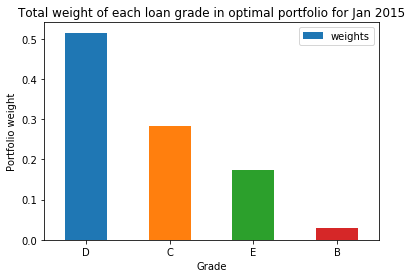

In [298]:
ax = group_by_grade.plot.bar(x='grade', y='weights', rot=0, title ="Total weight of each loan grade in optimal portfolio for Jan 2015")
ax.set_xlabel("Grade")
ax.set_ylabel("Portfolio weight")

In [299]:
(sample_df[['optimal_notionals', 'realized_loan_term_mths']].describe().T).to_csv("optimal_portf_stats.csv")

In [284]:
pd.read_csv("optimal_portf_stats.csv")

,statistic,#_loans,mean,min,25%,50%,75%,max
0,amount_to_invest($),100,10000,0,3011,7614,15991,35000
1,realized_loan_life(months),100,23,1,13,22,36,38
